the model was trained on google colab

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,StratifiedKFold,StratifiedShuffleSplit,ShuffleSplit
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler,RobustScaler,PolynomialFeatures,StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline 
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,StackingRegressor,VotingRegressor
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
import seaborn as sns

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
first_covid_date=datetime.timestamp(pd.to_datetime(["18/3/20"])[0])/(24*60*60)

In [ ]:
def create_date_feat(data):
    """
    1)the "days_before_or_after_covid" column is the number of days after first covid 19 case was announced in uganda,
    the days before covid 19 has negative values,the values are alson in decimal which differentiates the time period of each day from each other 
    2)"day_of_week" column is the day of week 
    3)"day" is day of month"""
    to_time=pd.to_datetime(data["created_at"])
    data["day"]=to_time.dt.day
    data["week"]=to_time.dt.week
    data["year"]=to_time.dt.year
    data["month"]=to_time.dt.month
    data["hour"]=to_time.dt.hour
    data["quarter"]=to_time.dt.quarter
    data["day_of_week"]=to_time.dt.dayofweek
    data["created_at"]=to_time
    data["days_before_or_after_covid"]=[datetime.timestamp(i)/(60*60*24) for i in to_time]
    data["days_before_or_after_covid"]=data["days_before_or_after_covid"]-first_covid_date

In [ ]:
def check_symbol(value):
  if value>0:
    return "-ve"
  elif value<0:
    return "+ve"
  else:
    return "0"

In [ ]:
 def create_cols(data):
   """
   1)"average_pm2_5" is the average of the value of pm2_5 from both sensors, the second sensor "s2_pm2_5" values has some and it was removed and replaced with value of "pm2_5" for same datapoints.
   2)"average_pm10" is the same as "average_pm2_5" but for "pm_10"
   3)"error_pm2_5" the absolute value of the difference between the two sensor values for pm2_5.
   4)"check_symbol_pm2_5" checks the symbol of the difference "error_pm2_5" whether it is positive,negative or zero.
   5)"error_pm10","check_symbol_pm10" same as 3 and 4 but for pm10.
   6)"pm2.5-pm10" the difference between "average_pm2_5" and "average_pm10" columns
   7)"pm2 5-pm10_%" ratio of "pm2.5-pm10" relative to "average_pm10"
   """
   data["s2_pm2_5"]=np.where(data["s2_pm2_5"]==0,data["pm2_5"],data["s2_pm2_5"])
   data["s2_pm10"]=np.where(data["s2_pm10"]==0,data["pm10"],data["s2_pm10"])
   data["average_pm2_5"]=(data["pm2_5"]+data["s2_pm2_5"])/2
   data["error_pm2_5"]=data["pm2_5"]-data["s2_pm2_5"]
   data["average_pm10"]=(data["pm10"]+data["s2_pm10"])/2
   data["error_pm10"]=data["pm10"]-data["s2_pm10"]
   data["pm2.5-pm10"]=data["average_pm10"]-data["average_pm2_5"]
   data["pm2 5-pm10_%"]=data["pm2.5-pm10"]/data["average_pm10"]
   data["check_symbol_pm2_5"]=data["error_pm2_5"].apply(check_symbol)
   data["check_symbol_pm10"]=data["error_pm10"].apply(check_symbol)
   data["error_pm10"]=np.abs(data["pm10"]-data["s2_pm10"])
   data["error_pm2_5"]=np.abs(data["pm2_5"]-data["s2_pm2_5"])
   data=data.drop(["s2_pm2_5","s2_pm10","pm2_5","pm10"],axis=1)
   return data

In [ ]:
def fillna(data):
  """splits the data based on location and replaces the missing values of some columns("temp" and "humidity") based on the mean.
  and i joined the data back"""
  ind_data=data.index
  data_embassy=data[data["site"]=="USEmbassy"]
  data_makerere=data[data["site"]=="Makerere"]
  data_nakawa=data[data["site"]=="Nakawa"]
  filled_each_site=[]
  for site_data in [data_embassy,data_makerere,data_nakawa]:
    m_1=site_data["temp"].mean()
    m_2=site_data["humidity"].mean()
    site_data["temp"]=site_data["temp"].fillna(m_1)
    site_data["humidity"]=site_data["humidity"].fillna(m_2)
    filled_each_site.append(site_data)
  data=shuffle(pd.concat(filled_each_site))
  data=data.loc[ind_data]
  return data

In [ ]:
def get_data():
  """ this loads the data,creates the new columns,removes the outliers,converts the "created_at" column to categorical(from datetime) and then to numerical (pd.factorize) 
  based on its ascending order.
  it returns the "cleaned" train and test data,and the target.

  I wrote this function so,I can load the data occasionaly especially during cross validation where i need to 
  scale(Robust Scaler) the test data ocassionally;to prevent contamination of the data  """
  train=pd.read_csv("/content/drive/MyDrive/kampala/Train_kampala.csv",index_col=0)
  test=pd.read_csv("/content/drive/MyDrive/kampala/Test_kampala.csv",index_col=0)
  test=fillna(test)
  train=fillna(train)
  train=create_cols(train)
  test=create_cols(test)
  create_date_feat(train)
  create_date_feat(test)
  data=pd.concat([train,test])
  train=train[train["ref_pm2_5"]<350]
  target=train[["ref_pm2_5","site"]]
  train.drop(["ref_pm2_5"],axis=1,inplace=True)
  data=pd.concat([train,test])
  train_ind=train.index
  test_ind=test.index
  data=data.sort_values(by="created_at",ascending=True)
  data["created_at"]=data["created_at"].astype("O")
  for col in data.columns:
    if data[col].dtype=="object":
      data[col]=pd.factorize(data[col])[0]
  train=data.loc[train_ind]
  test=data.loc[test_ind]
  return train,test,target

In [ ]:
train,test,target=get_data()
ind=test.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [ ]:
train['days_before_or_after_covid']

ID
ID_0038MG0B     36.583333
ID_008ASVDD    -23.333333
ID_009ACJQ9    311.041667
ID_00IGMAQ2   -104.750000
ID_00P76VAQ   -169.083333
                  ...    
ID_ZZJQLZN9   -215.000000
ID_ZZMUJIHC   -140.916667
ID_ZZQJ2T20    234.375000
ID_ZZSU9E05    201.666667
ID_ZZWSQXVL    -38.375000
Name: days_before_or_after_covid, Length: 10929, dtype: float64

In [ ]:
target

,ref_pm2_5,site
ID,,
ID_0038MG0B,25.0,USEmbassy
ID_008ASVDD,68.0,USEmbassy
ID_009ACJQ9,149.7,Nakawa
ID_00IGMAQ2,54.0,USEmbassy
ID_00P76VAQ,39.0,USEmbassy
...,...,...
ID_ZZJQLZN9,77.0,USEmbassy
ID_ZZMUJIHC,22.0,USEmbassy
ID_ZZQJ2T20,34.0,USEmbassy


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


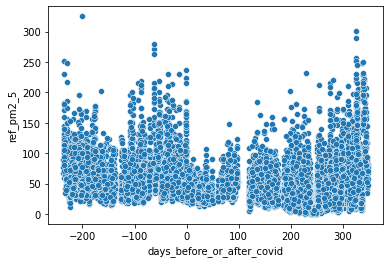

In [ ]:
sns.scatterplot(train['days_before_or_after_covid'],target["ref_pm2_5"])

In [ ]:
train_split,test,target_split=get_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [ ]:
def set_limit(val):
  #simple function to ensure that any of the submission values isn't less than 0.5
  if val<0:
    return 0.5
  else:
    return val

Stacking Regressor

In [ ]:
estimators=[("cat",CatBoostRegressor(**{'colsample_bylevel': 0.10251082245245978,
 'learning_rate': 0.020492395897155687,
 'max_depth': 6,
 'reg_lambda': 7,
 'subsample': 0.8160176938560509},eval_metric="RMSE",random_state=0,verbose=100,n_estimators=8000)),("c2",CatBoostRegressor(**{'colsample_bylevel': 0.3025385843387734, 'learning_rate': 0.029062720662205617, 'max_depth': 6, 'reg_lambda': 3, 'subsample': 0.49125441571305234},eval_metric="RMSE",random_state=0,verbose=100,n_estimators=8000))]

In [ ]:
pipe_final=Pipeline([("poly",PolynomialFeatures()),("scaler",MinMaxScaler()),("m",LinearRegression())])

In [ ]:
model_stack=StackingRegressor(estimators=estimators,verbose=2,cv=10,final_estimator=pipe_final)

In [ ]:
"""I cross-validated the data into ten different folds, I stratified it based on the "site"
  column so that the "site" from each fold will be distributed in the same ratio as the test/original train data (4:2:1), I scaled the data(train,val and test) 
  during each selection and i fitted the model on it.I saved my prediction for the test data for each fold on the train data in a dataframe ("predictions_frame")"""

'I cross-validated the data into ten different folds, I stratified it based on the "site"\n  column so that the "site" from each fold will be distributed in the same ratio as the test/original train data (4:2:1), I scaled the data(train,val and test) \n  during each selection and i fitted the model on it.I saved my prediction for the test data for each fold on the train data in a dataframe ("predictions_frame")'

In [ ]:
sss=StratifiedKFold(n_splits=10,random_state=2,shuffle=True)
predictions_frame=pd.DataFrame()
rmse=[]
preds=pd.DataFrame()
print(sss.split(train,target))
for i,(train_index,test_index) in enumerate(sss.split(train_split,target_split['site'])):
  train,test,target=get_data()
  print(train_index,test_index)
  train_ss=train.iloc[train_index]
  val_ss=train.iloc[test_index]
  y_ss=target["site"].iloc[train_index]
  y_val_ss=target["site"].iloc[test_index]
  y_ss=target["ref_pm2_5"].loc[y_ss.index]
  y_val_ss=target["ref_pm2_5"].loc[y_val_ss.index]
  scaler=RobustScaler()
  train_ss=scaler.fit_transform(train_ss)
  val_ss=scaler.transform(val_ss)
  test=scaler.transform(test)
  model_stack.fit(train_ss,y_ss)
  print(i)
  pred=model_stack.predict(val_ss)
  prediction=model_stack.predict(test)
  predictions_frame[i]=prediction
  rmse.append(np.sqrt(mean_squared_error(y_val_ss,pred)))

<generator object _BaseKFold.split at 0x7f5287f2ead0>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


[    0     1     2 ... 10926 10927 10928] [    4     7    10 ... 10901 10915 10918]
0:	learn: 34.9097516	total: 49ms	remaining: 6m 31s
100:	learn: 17.3916622	total: 266ms	remaining: 20.8s
200:	learn: 13.3520292	total: 483ms	remaining: 18.7s
300:	learn: 12.1412737	total: 679ms	remaining: 17.4s
400:	learn: 11.5267448	total: 883ms	remaining: 16.7s
500:	learn: 10.9779124	total: 1.1s	remaining: 16.5s
600:	learn: 10.5945633	total: 1.3s	remaining: 16s
700:	learn: 10.2220856	total: 1.52s	remaining: 15.9s
800:	learn: 9.9452814	total: 1.74s	remaining: 15.7s
900:	learn: 9.7241018	total: 1.96s	remaining: 15.5s
1000:	learn: 9.5493549	total: 2.18s	remaining: 15.2s
1100:	learn: 9.3797908	total: 2.4s	remaining: 15.1s
1200:	learn: 9.2335557	total: 2.62s	remaining: 14.8s
1300:	learn: 9.0893369	total: 2.84s	remaining: 14.6s
1400:	learn: 8.9741877	total: 3.05s	remaining: 14.3s
1500:	learn: 8.8447257	total: 3.27s	remaining: 14.2s
1600:	learn: 8.7415386	total: 3.48s	remaining: 13.9s
1700:	learn: 8.6525818	t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.8601914	total: 2.61ms	remaining: 20.9s
100:	learn: 17.4510397	total: 201ms	remaining: 15.7s
200:	learn: 13.3757902	total: 404ms	remaining: 15.7s
300:	learn: 12.1514335	total: 605ms	remaining: 15.5s
400:	learn: 11.5347697	total: 795ms	remaining: 15.1s
500:	learn: 11.0294436	total: 991ms	remaining: 14.8s
600:	learn: 10.6314771	total: 1.2s	remaining: 14.7s
700:	learn: 10.2712855	total: 1.39s	remaining: 14.5s
800:	learn: 9.9576945	total: 1.58s	remaining: 14.2s
900:	learn: 9.7194355	total: 1.78s	remaining: 14s
1000:	learn: 9.5190857	total: 1.99s	remaining: 13.9s
1100:	learn: 9.3526267	total: 2.19s	remaining: 13.8s
1200:	learn: 9.2121053	total: 2.38s	remaining: 13.5s
1300:	learn: 9.0612232	total: 2.58s	remaining: 13.3s
1400:	learn: 8.9485128	total: 2.76s	remaining: 13s
1500:	learn: 8.7996946	total: 2.98s	remaining: 12.9s
1600:	learn: 8.6873369	total: 3.17s	remaining: 12.7s
1700:	learn: 8.5845800	total: 3.36s	remaining: 12.4s
1800:	learn: 8.4720353	total: 3.56s	remaining: 12.3s
1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


0:	learn: 34.6873263	total: 2.04ms	remaining: 16.3s
100:	learn: 17.3181374	total: 203ms	remaining: 15.9s
200:	learn: 13.3017912	total: 394ms	remaining: 15.3s
300:	learn: 12.0680919	total: 593ms	remaining: 15.2s
400:	learn: 11.4343540	total: 776ms	remaining: 14.7s
500:	learn: 10.8839944	total: 969ms	remaining: 14.5s
600:	learn: 10.4886742	total: 1.15s	remaining: 14.2s
700:	learn: 10.1037574	total: 1.36s	remaining: 14.2s
800:	learn: 9.7980295	total: 1.55s	remaining: 13.9s
900:	learn: 9.5602935	total: 1.78s	remaining: 14s
1000:	learn: 9.3761333	total: 1.96s	remaining: 13.7s
1100:	learn: 9.1941691	total: 2.16s	remaining: 13.5s
1200:	learn: 9.0343352	total: 2.34s	remaining: 13.3s
1300:	learn: 8.8954991	total: 2.54s	remaining: 13.1s
1400:	learn: 8.7786246	total: 2.73s	remaining: 12.9s
1500:	learn: 8.6504378	total: 2.94s	remaining: 12.7s
1600:	learn: 8.5462659	total: 3.12s	remaining: 12.5s
1700:	learn: 8.4563529	total: 3.31s	remaining: 12.3s
1800:	learn: 8.3514627	total: 3.51s	remaining: 12.1

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.4935980	total: 2.87ms	remaining: 23s
100:	learn: 13.0650176	total: 308ms	remaining: 24.1s
200:	learn: 11.1598868	total: 586ms	remaining: 22.7s
300:	learn: 10.3200998	total: 884ms	remaining: 22.6s
400:	learn: 9.7756858	total: 1.18s	remaining: 22.3s
500:	learn: 9.3268550	total: 1.49s	remaining: 22.2s
600:	learn: 8.9281556	total: 1.77s	remaining: 21.9s
700:	learn: 8.6107131	total: 2.08s	remaining: 21.7s
800:	learn: 8.3432445	total: 2.37s	remaining: 21.3s
900:	learn: 8.0986972	total: 2.65s	remaining: 20.9s
1000:	learn: 7.8777779	total: 2.94s	remaining: 20.5s
1100:	learn: 7.6787817	total: 3.24s	remaining: 20.3s
1200:	learn: 7.4926242	total: 3.52s	remaining: 20s
1300:	learn: 7.3192987	total: 3.81s	remaining: 19.6s
1400:	learn: 7.1663749	total: 4.11s	remaining: 19.3s
1500:	learn: 7.0271936	total: 4.42s	remaining: 19.2s
1600:	learn: 6.8864334	total: 4.71s	remaining: 18.8s
1700:	learn: 6.7511813	total: 5s	remaining: 18.5s
1800:	learn: 6.6344560	total: 5.29s	remaining: 18.2s
1900:	l

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s remaining:    0.0s


0:	learn: 34.3129273	total: 2.85ms	remaining: 22.8s
100:	learn: 12.9353624	total: 302ms	remaining: 23.6s
200:	learn: 11.0783774	total: 589ms	remaining: 22.9s
300:	learn: 10.1830727	total: 888ms	remaining: 22.7s
400:	learn: 9.6214870	total: 1.18s	remaining: 22.3s
500:	learn: 9.1786088	total: 1.46s	remaining: 21.9s
600:	learn: 8.8279472	total: 1.75s	remaining: 21.5s
700:	learn: 8.5133381	total: 2.04s	remaining: 21.3s
800:	learn: 8.2604620	total: 2.33s	remaining: 20.9s
900:	learn: 8.0195838	total: 2.61s	remaining: 20.5s
1000:	learn: 7.7937648	total: 2.9s	remaining: 20.3s
1100:	learn: 7.5980319	total: 3.18s	remaining: 19.9s
1200:	learn: 7.4305481	total: 3.49s	remaining: 19.7s
1300:	learn: 7.2585566	total: 3.76s	remaining: 19.4s
1400:	learn: 7.1000038	total: 4.05s	remaining: 19.1s
1500:	learn: 6.9540904	total: 4.34s	remaining: 18.8s
1600:	learn: 6.8147303	total: 4.63s	remaining: 18.5s
1700:	learn: 6.6921071	total: 4.91s	remaining: 18.2s
1800:	learn: 6.5757314	total: 5.2s	remaining: 17.9s
19

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    0     1     2 ... 10926 10927 10928] [    6     9    21 ... 10920 10922 10923]
0:	learn: 34.7681141	total: 2.67ms	remaining: 21.3s
100:	learn: 17.3533124	total: 214ms	remaining: 16.7s
200:	learn: 13.4576979	total: 439ms	remaining: 17s
300:	learn: 12.2876879	total: 655ms	remaining: 16.8s
400:	learn: 11.6789911	total: 874ms	remaining: 16.6s
500:	learn: 11.1957392	total: 1.08s	remaining: 16.2s
600:	learn: 10.8411350	total: 1.3s	remaining: 16s
700:	learn: 10.4857483	total: 1.53s	remaining: 15.9s
800:	learn: 10.1860856	total: 1.75s	remaining: 15.7s
900:	learn: 9.9572880	total: 1.97s	remaining: 15.6s
1000:	learn: 9.7593513	total: 2.19s	remaining: 15.3s
1100:	learn: 9.6007711	total: 2.42s	remaining: 15.1s
1200:	learn: 9.4404739	total: 2.63s	remaining: 14.9s
1300:	learn: 9.3076063	total: 2.84s	remaining: 14.6s
1400:	learn: 9.1924593	total: 3.06s	remaining: 14.4s
1500:	learn: 9.0608939	total: 3.28s	remaining: 14.2s
1600:	learn: 8.9594133	total: 3.5s	remaining: 14s
1700:	learn: 8.8733714	to

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.6653836	total: 2.15ms	remaining: 17.2s
100:	learn: 17.1400810	total: 207ms	remaining: 16.1s
200:	learn: 13.4343027	total: 413ms	remaining: 16s
300:	learn: 12.3347075	total: 610ms	remaining: 15.6s
400:	learn: 11.7603086	total: 814ms	remaining: 15.4s
500:	learn: 11.2851254	total: 1s	remaining: 15s
600:	learn: 10.8828182	total: 1.2s	remaining: 14.8s
700:	learn: 10.5094748	total: 1.4s	remaining: 14.5s
800:	learn: 10.1946705	total: 1.61s	remaining: 14.5s
900:	learn: 9.9369842	total: 1.8s	remaining: 14.2s
1000:	learn: 9.7306199	total: 2s	remaining: 14s
1100:	learn: 9.5532599	total: 2.21s	remaining: 13.9s
1200:	learn: 9.4023254	total: 2.4s	remaining: 13.6s
1300:	learn: 9.2404174	total: 2.61s	remaining: 13.4s
1400:	learn: 9.1131814	total: 2.79s	remaining: 13.1s
1500:	learn: 8.9783846	total: 3.01s	remaining: 13s
1600:	learn: 8.8695182	total: 3.19s	remaining: 12.8s
1700:	learn: 8.7738161	total: 3.38s	remaining: 12.5s
1800:	learn: 8.6615634	total: 3.58s	remaining: 12.3s
1900:	learn: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


0:	learn: 34.6090825	total: 2ms	remaining: 16s
100:	learn: 17.6131957	total: 207ms	remaining: 16.2s
200:	learn: 13.3939126	total: 416ms	remaining: 16.1s
300:	learn: 12.2050915	total: 607ms	remaining: 15.5s
400:	learn: 11.5650148	total: 806ms	remaining: 15.3s
500:	learn: 11.0544530	total: 1.02s	remaining: 15.3s
600:	learn: 10.6764333	total: 1.23s	remaining: 15.1s
700:	learn: 10.3445624	total: 1.43s	remaining: 14.9s
800:	learn: 10.0232770	total: 1.62s	remaining: 14.6s
900:	learn: 9.8031288	total: 1.83s	remaining: 14.4s
1000:	learn: 9.6107061	total: 2.04s	remaining: 14.3s
1100:	learn: 9.4415136	total: 2.25s	remaining: 14.1s
1200:	learn: 9.3050054	total: 2.44s	remaining: 13.8s
1300:	learn: 9.1534632	total: 2.65s	remaining: 13.6s
1400:	learn: 9.0196850	total: 2.84s	remaining: 13.4s
1500:	learn: 8.8897621	total: 3.05s	remaining: 13.2s
1600:	learn: 8.7756137	total: 3.25s	remaining: 13s
1700:	learn: 8.6792759	total: 3.44s	remaining: 12.7s
1800:	learn: 8.5803310	total: 3.64s	remaining: 12.5s
19

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.3070842	total: 2.94ms	remaining: 23.5s
100:	learn: 13.1681673	total: 296ms	remaining: 23.1s
200:	learn: 11.3607439	total: 574ms	remaining: 22.3s
300:	learn: 10.5196741	total: 858ms	remaining: 21.9s
400:	learn: 9.9413546	total: 1.13s	remaining: 21.5s
500:	learn: 9.5085191	total: 1.41s	remaining: 21.1s
600:	learn: 9.1418247	total: 1.7s	remaining: 20.9s
700:	learn: 8.8182457	total: 1.98s	remaining: 20.6s
800:	learn: 8.5439557	total: 2.26s	remaining: 20.4s
900:	learn: 8.2834934	total: 2.54s	remaining: 20s
1000:	learn: 8.0500406	total: 2.84s	remaining: 19.8s
1100:	learn: 7.8574220	total: 3.13s	remaining: 19.6s
1200:	learn: 7.6674383	total: 3.41s	remaining: 19.3s
1300:	learn: 7.5119781	total: 3.7s	remaining: 19s
1400:	learn: 7.3405191	total: 3.98s	remaining: 18.8s
1500:	learn: 7.1898681	total: 4.28s	remaining: 18.5s
1600:	learn: 7.0484500	total: 4.56s	remaining: 18.2s
1700:	learn: 6.9152978	total: 4.84s	remaining: 17.9s
1800:	learn: 6.7882554	total: 5.12s	remaining: 17.6s
1900:	

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s


0:	learn: 34.2420188	total: 2.8ms	remaining: 22.4s
100:	learn: 12.9801300	total: 289ms	remaining: 22.6s
200:	learn: 11.1508622	total: 576ms	remaining: 22.3s
300:	learn: 10.3317881	total: 888ms	remaining: 22.7s
400:	learn: 9.7881434	total: 1.2s	remaining: 22.7s
500:	learn: 9.3646909	total: 1.49s	remaining: 22.3s
600:	learn: 9.0063460	total: 1.8s	remaining: 22.2s
700:	learn: 8.7178994	total: 2.1s	remaining: 21.9s
800:	learn: 8.4673656	total: 2.41s	remaining: 21.7s
900:	learn: 8.2381953	total: 2.69s	remaining: 21.2s
1000:	learn: 8.0222694	total: 2.99s	remaining: 20.9s
1100:	learn: 7.8287734	total: 3.3s	remaining: 20.7s
1200:	learn: 7.6471605	total: 3.61s	remaining: 20.4s
1300:	learn: 7.4746927	total: 3.9s	remaining: 20.1s
1400:	learn: 7.3225504	total: 4.19s	remaining: 19.7s
1500:	learn: 7.1793011	total: 4.49s	remaining: 19.4s
1600:	learn: 7.0388244	total: 4.78s	remaining: 19.1s
1700:	learn: 6.9003990	total: 5.07s	remaining: 18.8s
1800:	learn: 6.7750844	total: 5.36s	remaining: 18.5s
1900:	

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    0     1     2 ... 10926 10927 10928] [    8    14    28 ... 10879 10900 10913]
0:	learn: 34.6307823	total: 2.25ms	remaining: 18s
100:	learn: 17.0972807	total: 211ms	remaining: 16.5s
200:	learn: 13.3938220	total: 416ms	remaining: 16.1s
300:	learn: 12.2423211	total: 633ms	remaining: 16.2s
400:	learn: 11.6345476	total: 837ms	remaining: 15.9s
500:	learn: 11.1741473	total: 1.05s	remaining: 15.8s
600:	learn: 10.7927106	total: 1.27s	remaining: 15.6s
700:	learn: 10.4615295	total: 1.5s	remaining: 15.6s
800:	learn: 10.1887147	total: 1.73s	remaining: 15.6s
900:	learn: 9.9851998	total: 1.95s	remaining: 15.4s
1000:	learn: 9.7869209	total: 2.16s	remaining: 15.1s
1100:	learn: 9.6281199	total: 2.39s	remaining: 15s
1200:	learn: 9.4847158	total: 2.61s	remaining: 14.8s
1300:	learn: 9.3444752	total: 2.83s	remaining: 14.6s
1400:	learn: 9.2328063	total: 3.04s	remaining: 14.3s
1500:	learn: 9.1087581	total: 3.26s	remaining: 14.1s
1600:	learn: 8.9981287	total: 3.48s	remaining: 13.9s
1700:	learn: 8.9037482

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.5750297	total: 2.35ms	remaining: 18.8s
100:	learn: 17.4121344	total: 201ms	remaining: 15.8s
200:	learn: 13.4643161	total: 391ms	remaining: 15.2s
300:	learn: 12.2545094	total: 584ms	remaining: 14.9s
400:	learn: 11.6449927	total: 773ms	remaining: 14.6s
500:	learn: 11.1291512	total: 973ms	remaining: 14.6s
600:	learn: 10.7509388	total: 1.16s	remaining: 14.2s
700:	learn: 10.4111974	total: 1.36s	remaining: 14.1s
800:	learn: 10.1228595	total: 1.54s	remaining: 13.9s
900:	learn: 9.9056410	total: 1.75s	remaining: 13.8s
1000:	learn: 9.7283675	total: 1.94s	remaining: 13.6s
1100:	learn: 9.5549417	total: 2.15s	remaining: 13.5s
1200:	learn: 9.3944643	total: 2.34s	remaining: 13.3s
1300:	learn: 9.2489621	total: 2.55s	remaining: 13.1s
1400:	learn: 9.1293761	total: 2.74s	remaining: 12.9s
1500:	learn: 8.9925076	total: 2.94s	remaining: 12.7s
1600:	learn: 8.8868829	total: 3.12s	remaining: 12.5s
1700:	learn: 8.7894851	total: 3.31s	remaining: 12.3s
1800:	learn: 8.6835782	total: 3.52s	remaining: 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s


0:	learn: 34.4635539	total: 2.1ms	remaining: 16.8s
100:	learn: 17.3747908	total: 192ms	remaining: 15s
200:	learn: 13.3935975	total: 395ms	remaining: 15.3s
300:	learn: 12.1852761	total: 597ms	remaining: 15.3s
400:	learn: 11.5215152	total: 789ms	remaining: 14.9s
500:	learn: 11.0326177	total: 988ms	remaining: 14.8s
600:	learn: 10.6662518	total: 1.18s	remaining: 14.5s
700:	learn: 10.2939864	total: 1.38s	remaining: 14.4s
800:	learn: 9.9949403	total: 1.59s	remaining: 14.3s
900:	learn: 9.7762850	total: 1.8s	remaining: 14.2s
1000:	learn: 9.5804114	total: 1.99s	remaining: 13.9s
1100:	learn: 9.4160111	total: 2.19s	remaining: 13.8s
1200:	learn: 9.2783757	total: 2.41s	remaining: 13.6s
1300:	learn: 9.1311766	total: 2.62s	remaining: 13.5s
1400:	learn: 9.0077335	total: 2.8s	remaining: 13.2s
1500:	learn: 8.8781324	total: 3.01s	remaining: 13s
1600:	learn: 8.7758899	total: 3.19s	remaining: 12.8s
1700:	learn: 8.6774453	total: 3.4s	remaining: 12.6s
1800:	learn: 8.5553878	total: 3.63s	remaining: 12.5s
1900

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.2264742	total: 2.84ms	remaining: 22.7s
100:	learn: 13.1687960	total: 287ms	remaining: 22.5s
200:	learn: 11.3183065	total: 576ms	remaining: 22.3s
300:	learn: 10.4621436	total: 866ms	remaining: 22.1s
400:	learn: 9.8989150	total: 1.16s	remaining: 22s
500:	learn: 9.4778642	total: 1.45s	remaining: 21.7s
600:	learn: 9.1116697	total: 1.74s	remaining: 21.4s
700:	learn: 8.8174364	total: 2.03s	remaining: 21.2s
800:	learn: 8.5518232	total: 2.34s	remaining: 21s
900:	learn: 8.3090710	total: 2.64s	remaining: 20.8s
1000:	learn: 8.0710090	total: 2.97s	remaining: 20.7s
1100:	learn: 7.8700032	total: 3.27s	remaining: 20.5s
1200:	learn: 7.6823446	total: 3.55s	remaining: 20.1s
1300:	learn: 7.5153335	total: 3.84s	remaining: 19.8s
1400:	learn: 7.3679357	total: 4.13s	remaining: 19.4s
1500:	learn: 7.2144294	total: 4.42s	remaining: 19.1s
1600:	learn: 7.0701148	total: 4.7s	remaining: 18.8s
1700:	learn: 6.9355649	total: 5s	remaining: 18.5s
1800:	learn: 6.8076716	total: 5.29s	remaining: 18.2s
1900:	le

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.4s remaining:    0.0s


0:	learn: 34.0854975	total: 2.75ms	remaining: 22s
100:	learn: 13.1527243	total: 289ms	remaining: 22.6s
200:	learn: 11.1832294	total: 579ms	remaining: 22.5s
300:	learn: 10.3831930	total: 869ms	remaining: 22.2s
400:	learn: 9.8180816	total: 1.16s	remaining: 22s
500:	learn: 9.3923986	total: 1.45s	remaining: 21.7s
600:	learn: 9.0320459	total: 1.74s	remaining: 21.4s
700:	learn: 8.7150053	total: 2.04s	remaining: 21.2s
800:	learn: 8.4551498	total: 2.32s	remaining: 20.9s
900:	learn: 8.2143740	total: 2.62s	remaining: 20.6s
1000:	learn: 8.0010595	total: 2.93s	remaining: 20.5s
1100:	learn: 7.8088723	total: 3.23s	remaining: 20.2s
1200:	learn: 7.6280965	total: 3.53s	remaining: 20s
1300:	learn: 7.4659003	total: 3.82s	remaining: 19.6s
1400:	learn: 7.3101226	total: 4.11s	remaining: 19.4s
1500:	learn: 7.1701216	total: 4.4s	remaining: 19.1s
1600:	learn: 7.0381600	total: 4.69s	remaining: 18.7s
1700:	learn: 6.8949613	total: 4.99s	remaining: 18.5s
1800:	learn: 6.7722040	total: 5.28s	remaining: 18.2s
1900:	l

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    0     1     3 ... 10926 10927 10928] [    2     5    16 ... 10820 10860 10874]
0:	learn: 34.7201177	total: 2.24ms	remaining: 18s
100:	learn: 16.9283471	total: 218ms	remaining: 17.1s
200:	learn: 13.2489517	total: 437ms	remaining: 17s
300:	learn: 12.1361456	total: 660ms	remaining: 16.9s
400:	learn: 11.5666191	total: 882ms	remaining: 16.7s
500:	learn: 11.0778807	total: 1.11s	remaining: 16.6s
600:	learn: 10.7008936	total: 1.31s	remaining: 16.2s
700:	learn: 10.3544350	total: 1.54s	remaining: 16s
800:	learn: 10.0798012	total: 1.77s	remaining: 15.9s
900:	learn: 9.8519808	total: 1.99s	remaining: 15.6s
1000:	learn: 9.6673727	total: 2.2s	remaining: 15.4s
1100:	learn: 9.5065942	total: 2.41s	remaining: 15.1s
1200:	learn: 9.3690041	total: 2.63s	remaining: 14.9s
1300:	learn: 9.2290384	total: 2.86s	remaining: 14.7s
1400:	learn: 9.1048923	total: 3.06s	remaining: 14.4s
1500:	learn: 8.9763087	total: 3.28s	remaining: 14.2s
1600:	learn: 8.8736894	total: 3.49s	remaining: 13.9s
1700:	learn: 8.7789481	t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.6083992	total: 2.32ms	remaining: 18.6s
100:	learn: 17.0308115	total: 224ms	remaining: 17.5s
200:	learn: 13.2724760	total: 435ms	remaining: 16.9s
300:	learn: 12.0671148	total: 635ms	remaining: 16.2s
400:	learn: 11.5034745	total: 830ms	remaining: 15.7s
500:	learn: 10.9968852	total: 1.04s	remaining: 15.5s
600:	learn: 10.6066785	total: 1.24s	remaining: 15.3s
700:	learn: 10.2508619	total: 1.46s	remaining: 15.2s
800:	learn: 9.9631785	total: 1.65s	remaining: 14.8s
900:	learn: 9.7294192	total: 1.88s	remaining: 14.8s
1000:	learn: 9.5296002	total: 2.09s	remaining: 14.6s
1100:	learn: 9.3723436	total: 2.29s	remaining: 14.4s
1200:	learn: 9.2118832	total: 2.5s	remaining: 14.2s
1300:	learn: 9.0634182	total: 2.72s	remaining: 14s
1400:	learn: 8.9434603	total: 2.9s	remaining: 13.7s
1500:	learn: 8.8099413	total: 3.13s	remaining: 13.6s
1600:	learn: 8.7021946	total: 3.33s	remaining: 13.3s
1700:	learn: 8.6106893	total: 3.54s	remaining: 13.1s
1800:	learn: 8.4988966	total: 3.74s	remaining: 12.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


0:	learn: 34.6640714	total: 1.99ms	remaining: 16s
100:	learn: 17.3193628	total: 217ms	remaining: 17s
200:	learn: 13.3092755	total: 408ms	remaining: 15.8s
300:	learn: 12.0408125	total: 611ms	remaining: 15.6s
400:	learn: 11.4136971	total: 822ms	remaining: 15.6s
500:	learn: 10.8943821	total: 1.01s	remaining: 15.2s
600:	learn: 10.5025775	total: 1.21s	remaining: 14.9s
700:	learn: 10.1691861	total: 1.42s	remaining: 14.8s
800:	learn: 9.8853618	total: 1.62s	remaining: 14.6s
900:	learn: 9.6768988	total: 1.83s	remaining: 14.5s
1000:	learn: 9.4699645	total: 2.04s	remaining: 14.2s
1100:	learn: 9.2907137	total: 2.25s	remaining: 14.1s
1200:	learn: 9.1620467	total: 2.43s	remaining: 13.8s
1300:	learn: 9.0250762	total: 2.63s	remaining: 13.6s
1400:	learn: 8.9062796	total: 2.83s	remaining: 13.3s
1500:	learn: 8.7785347	total: 3.03s	remaining: 13.1s
1600:	learn: 8.6676879	total: 3.23s	remaining: 12.9s
1700:	learn: 8.5788934	total: 3.42s	remaining: 12.7s
1800:	learn: 8.4781855	total: 3.62s	remaining: 12.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.2426483	total: 2.76ms	remaining: 22.1s
100:	learn: 12.9642992	total: 300ms	remaining: 23.4s
200:	learn: 11.2404773	total: 631ms	remaining: 24.5s
300:	learn: 10.3416631	total: 920ms	remaining: 23.5s
400:	learn: 9.8453441	total: 1.2s	remaining: 22.8s
500:	learn: 9.3578685	total: 1.5s	remaining: 22.4s
600:	learn: 8.9675163	total: 1.79s	remaining: 22s
700:	learn: 8.6284726	total: 2.11s	remaining: 21.9s
800:	learn: 8.3669798	total: 2.4s	remaining: 21.6s
900:	learn: 8.1331371	total: 2.68s	remaining: 21.1s
1000:	learn: 7.9152731	total: 2.98s	remaining: 20.9s
1100:	learn: 7.7189227	total: 3.29s	remaining: 20.6s
1200:	learn: 7.5382682	total: 3.59s	remaining: 20.3s
1300:	learn: 7.3578481	total: 3.87s	remaining: 19.9s
1400:	learn: 7.2106772	total: 4.15s	remaining: 19.6s
1500:	learn: 7.0651326	total: 4.45s	remaining: 19.3s
1600:	learn: 6.9303652	total: 4.74s	remaining: 18.9s
1700:	learn: 6.7954814	total: 5.04s	remaining: 18.7s
1800:	learn: 6.6685389	total: 5.34s	remaining: 18.4s
1900:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s remaining:    0.0s


0:	learn: 34.3049824	total: 2.82ms	remaining: 22.6s
100:	learn: 12.9365364	total: 295ms	remaining: 23.1s
200:	learn: 11.1668372	total: 586ms	remaining: 22.8s
300:	learn: 10.2989416	total: 876ms	remaining: 22.4s
400:	learn: 9.7502642	total: 1.16s	remaining: 22.1s
500:	learn: 9.3388274	total: 1.45s	remaining: 21.7s
600:	learn: 8.9694793	total: 1.75s	remaining: 21.6s
700:	learn: 8.6626744	total: 2.06s	remaining: 21.4s
800:	learn: 8.4052951	total: 2.34s	remaining: 21.1s
900:	learn: 8.1650292	total: 2.63s	remaining: 20.7s
1000:	learn: 7.9693184	total: 2.94s	remaining: 20.6s
1100:	learn: 7.7817760	total: 3.23s	remaining: 20.3s
1200:	learn: 7.6075427	total: 3.53s	remaining: 20s
1300:	learn: 7.4194779	total: 3.83s	remaining: 19.7s
1400:	learn: 7.2775528	total: 4.12s	remaining: 19.4s
1500:	learn: 7.1368746	total: 4.41s	remaining: 19.1s
1600:	learn: 7.0009497	total: 4.71s	remaining: 18.8s
1700:	learn: 6.8775268	total: 5s	remaining: 18.5s
1800:	learn: 6.7607692	total: 5.3s	remaining: 18.3s
1900:	

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    0     1     2 ... 10925 10926 10927] [   11    35    46 ... 10914 10924 10928]
0:	learn: 34.6127046	total: 2.5ms	remaining: 20s
100:	learn: 17.4732760	total: 232ms	remaining: 18.1s
200:	learn: 13.4075776	total: 462ms	remaining: 17.9s
300:	learn: 12.2510160	total: 663ms	remaining: 16.9s
400:	learn: 11.6740311	total: 910ms	remaining: 17.2s
500:	learn: 11.1676683	total: 1.14s	remaining: 17s
600:	learn: 10.8069316	total: 1.34s	remaining: 16.5s
700:	learn: 10.4885922	total: 1.58s	remaining: 16.5s
800:	learn: 10.2125269	total: 1.8s	remaining: 16.1s
900:	learn: 9.9846452	total: 2.01s	remaining: 15.9s
1000:	learn: 9.7683490	total: 2.24s	remaining: 15.7s
1100:	learn: 9.6052101	total: 2.45s	remaining: 15.4s
1200:	learn: 9.4501733	total: 2.67s	remaining: 15.1s
1300:	learn: 9.3154128	total: 2.9s	remaining: 14.9s
1400:	learn: 9.1938576	total: 3.13s	remaining: 14.7s
1500:	learn: 9.0738156	total: 3.36s	remaining: 14.5s
1600:	learn: 8.9734769	total: 3.58s	remaining: 14.3s
1700:	learn: 8.8735198	t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.6203090	total: 2.22ms	remaining: 17.7s
100:	learn: 17.0351361	total: 200ms	remaining: 15.7s
200:	learn: 13.3474036	total: 431ms	remaining: 16.7s
300:	learn: 12.2314137	total: 625ms	remaining: 16s
400:	learn: 11.6713045	total: 835ms	remaining: 15.8s
500:	learn: 11.1868816	total: 1.02s	remaining: 15.3s
600:	learn: 10.8185076	total: 1.22s	remaining: 15.1s
700:	learn: 10.4913371	total: 1.44s	remaining: 15s
800:	learn: 10.1975284	total: 1.63s	remaining: 14.6s
900:	learn: 9.9545107	total: 1.82s	remaining: 14.4s
1000:	learn: 9.7659242	total: 2.01s	remaining: 14.1s
1100:	learn: 9.5855696	total: 2.23s	remaining: 14s
1200:	learn: 9.4310826	total: 2.42s	remaining: 13.7s
1300:	learn: 9.2813079	total: 2.63s	remaining: 13.5s
1400:	learn: 9.1487514	total: 2.81s	remaining: 13.3s
1500:	learn: 9.0156355	total: 3.02s	remaining: 13.1s
1600:	learn: 8.8994291	total: 3.21s	remaining: 12.8s
1700:	learn: 8.7939625	total: 3.41s	remaining: 12.6s
1800:	learn: 8.6833137	total: 3.62s	remaining: 12.5s
1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


0:	learn: 34.4838891	total: 2.08ms	remaining: 16.6s
100:	learn: 16.8940334	total: 213ms	remaining: 16.7s
200:	learn: 13.2326119	total: 428ms	remaining: 16.6s
300:	learn: 12.0644619	total: 640ms	remaining: 16.4s
400:	learn: 11.4954143	total: 826ms	remaining: 15.7s
500:	learn: 10.9989051	total: 1.02s	remaining: 15.3s
600:	learn: 10.6127563	total: 1.2s	remaining: 14.8s
700:	learn: 10.2785185	total: 1.41s	remaining: 14.6s
800:	learn: 9.9830885	total: 1.6s	remaining: 14.4s
900:	learn: 9.7487536	total: 1.82s	remaining: 14.3s
1000:	learn: 9.5608154	total: 2.01s	remaining: 14.1s
1100:	learn: 9.3947212	total: 2.22s	remaining: 13.9s
1200:	learn: 9.2319803	total: 2.42s	remaining: 13.7s
1300:	learn: 9.0949301	total: 2.61s	remaining: 13.4s
1400:	learn: 8.9711906	total: 2.8s	remaining: 13.2s
1500:	learn: 8.8382896	total: 3.01s	remaining: 13s
1600:	learn: 8.7296560	total: 3.19s	remaining: 12.8s
1700:	learn: 8.6368062	total: 3.39s	remaining: 12.6s
1800:	learn: 8.5325084	total: 3.6s	remaining: 12.4s
19

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.2392151	total: 3.96ms	remaining: 31.6s
100:	learn: 13.1415693	total: 315ms	remaining: 24.7s
200:	learn: 11.2662485	total: 605ms	remaining: 23.5s
300:	learn: 10.5228310	total: 896ms	remaining: 22.9s
400:	learn: 9.9556213	total: 1.18s	remaining: 22.4s
500:	learn: 9.5053500	total: 1.48s	remaining: 22.1s
600:	learn: 9.1216600	total: 1.77s	remaining: 21.8s
700:	learn: 8.8013035	total: 2.07s	remaining: 21.6s
800:	learn: 8.4983427	total: 2.38s	remaining: 21.3s
900:	learn: 8.2490165	total: 2.67s	remaining: 21s
1000:	learn: 8.0082667	total: 2.97s	remaining: 20.7s
1100:	learn: 7.8159062	total: 3.26s	remaining: 20.4s
1200:	learn: 7.6372387	total: 3.55s	remaining: 20.1s
1300:	learn: 7.4733618	total: 3.85s	remaining: 19.8s
1400:	learn: 7.3242007	total: 4.15s	remaining: 19.6s
1500:	learn: 7.1696607	total: 4.45s	remaining: 19.3s
1600:	learn: 7.0345169	total: 4.75s	remaining: 19s
1700:	learn: 6.8983299	total: 5.05s	remaining: 18.7s
1800:	learn: 6.7755934	total: 5.35s	remaining: 18.4s
1900

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s


0:	learn: 34.1077575	total: 3.44ms	remaining: 27.5s
100:	learn: 12.8594706	total: 305ms	remaining: 23.8s
200:	learn: 11.1213990	total: 598ms	remaining: 23.2s
300:	learn: 10.3052451	total: 900ms	remaining: 23s
400:	learn: 9.7431886	total: 1.19s	remaining: 22.6s
500:	learn: 9.3160579	total: 1.49s	remaining: 22.3s
600:	learn: 8.9628958	total: 1.78s	remaining: 22s
700:	learn: 8.6718909	total: 2.08s	remaining: 21.7s
800:	learn: 8.4302581	total: 2.38s	remaining: 21.4s
900:	learn: 8.1978667	total: 2.66s	remaining: 21s
1000:	learn: 7.9772996	total: 2.96s	remaining: 20.7s
1100:	learn: 7.7819815	total: 3.25s	remaining: 20.4s
1200:	learn: 7.5941124	total: 3.55s	remaining: 20.1s
1300:	learn: 7.4259793	total: 3.83s	remaining: 19.7s
1400:	learn: 7.2712418	total: 4.12s	remaining: 19.4s
1500:	learn: 7.1099326	total: 4.42s	remaining: 19.1s
1600:	learn: 6.9750348	total: 4.7s	remaining: 18.8s
1700:	learn: 6.8384561	total: 4.99s	remaining: 18.5s
1800:	learn: 6.7171370	total: 5.29s	remaining: 18.2s
1900:	l

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


[    0     1     2 ... 10926 10927 10928] [   22    24    58 ... 10886 10921 10925]
0:	learn: 34.7013385	total: 2.41ms	remaining: 19.3s
100:	learn: 17.3158064	total: 221ms	remaining: 17.3s
200:	learn: 13.3553197	total: 444ms	remaining: 17.2s
300:	learn: 12.1920002	total: 642ms	remaining: 16.4s
400:	learn: 11.6038306	total: 849ms	remaining: 16.1s
500:	learn: 11.0739472	total: 1.07s	remaining: 16.1s
600:	learn: 10.7008354	total: 1.3s	remaining: 16s
700:	learn: 10.3443148	total: 1.52s	remaining: 15.8s
800:	learn: 10.0599330	total: 1.73s	remaining: 15.5s
900:	learn: 9.8489887	total: 1.95s	remaining: 15.4s
1000:	learn: 9.6610261	total: 2.17s	remaining: 15.2s
1100:	learn: 9.5012110	total: 2.4s	remaining: 15s
1200:	learn: 9.3615750	total: 2.6s	remaining: 14.7s
1300:	learn: 9.2182806	total: 2.81s	remaining: 14.5s
1400:	learn: 9.0971410	total: 3.02s	remaining: 14.2s
1500:	learn: 8.9682288	total: 3.25s	remaining: 14.1s
1600:	learn: 8.8618563	total: 3.47s	remaining: 13.9s
1700:	learn: 8.7769614	t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.6114520	total: 2.2ms	remaining: 17.6s
100:	learn: 17.4312827	total: 208ms	remaining: 16.3s
200:	learn: 13.4461721	total: 406ms	remaining: 15.7s
300:	learn: 12.2696855	total: 620ms	remaining: 15.8s
400:	learn: 11.6671345	total: 827ms	remaining: 15.7s
500:	learn: 11.1442319	total: 1.01s	remaining: 15.2s
600:	learn: 10.7676762	total: 1.21s	remaining: 14.9s
700:	learn: 10.4227608	total: 1.41s	remaining: 14.7s
800:	learn: 10.1270022	total: 1.63s	remaining: 14.6s
900:	learn: 9.9092299	total: 1.85s	remaining: 14.6s
1000:	learn: 9.7296318	total: 2.04s	remaining: 14.3s
1100:	learn: 9.5600432	total: 2.24s	remaining: 14s
1200:	learn: 9.3992543	total: 2.43s	remaining: 13.7s
1300:	learn: 9.2513923	total: 2.64s	remaining: 13.6s
1400:	learn: 9.1344691	total: 2.83s	remaining: 13.4s
1500:	learn: 8.9967176	total: 3.04s	remaining: 13.2s
1600:	learn: 8.8759776	total: 3.23s	remaining: 12.9s
1700:	learn: 8.7759629	total: 3.43s	remaining: 12.7s
1800:	learn: 8.6711746	total: 3.63s	remaining: 12.5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


0:	learn: 34.4740827	total: 2.07ms	remaining: 16.6s
100:	learn: 17.3244460	total: 204ms	remaining: 16s
200:	learn: 13.2970247	total: 401ms	remaining: 15.5s
300:	learn: 12.1039132	total: 602ms	remaining: 15.4s
400:	learn: 11.5063509	total: 800ms	remaining: 15.2s
500:	learn: 10.9709206	total: 1s	remaining: 15s
600:	learn: 10.5795261	total: 1.2s	remaining: 14.8s
700:	learn: 10.1937459	total: 1.4s	remaining: 14.6s
800:	learn: 9.9067363	total: 1.61s	remaining: 14.5s
900:	learn: 9.6829997	total: 1.83s	remaining: 14.4s
1000:	learn: 9.4970063	total: 2.03s	remaining: 14.2s
1100:	learn: 9.3246765	total: 2.23s	remaining: 14s
1200:	learn: 9.1800588	total: 2.43s	remaining: 13.7s
1300:	learn: 9.0249621	total: 2.63s	remaining: 13.5s
1400:	learn: 8.9016291	total: 2.83s	remaining: 13.3s
1500:	learn: 8.7711632	total: 3.04s	remaining: 13.2s
1600:	learn: 8.6701155	total: 3.24s	remaining: 13s
1700:	learn: 8.5690742	total: 3.44s	remaining: 12.7s
1800:	learn: 8.4696509	total: 3.64s	remaining: 12.5s
1900:	lea

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.2559463	total: 3ms	remaining: 24s
100:	learn: 13.1441191	total: 317ms	remaining: 24.8s
200:	learn: 11.2527731	total: 610ms	remaining: 23.7s
300:	learn: 10.4640281	total: 895ms	remaining: 22.9s
400:	learn: 9.8843411	total: 1.18s	remaining: 22.4s
500:	learn: 9.4486598	total: 1.46s	remaining: 21.9s
600:	learn: 9.0939029	total: 1.75s	remaining: 21.6s
700:	learn: 8.7792052	total: 2.05s	remaining: 21.3s
800:	learn: 8.5146999	total: 2.33s	remaining: 20.9s
900:	learn: 8.2899634	total: 2.61s	remaining: 20.6s
1000:	learn: 8.0567874	total: 2.91s	remaining: 20.4s
1100:	learn: 7.8501636	total: 3.19s	remaining: 20s
1200:	learn: 7.6696010	total: 3.48s	remaining: 19.7s
1300:	learn: 7.4847925	total: 3.77s	remaining: 19.4s
1400:	learn: 7.3235047	total: 4.06s	remaining: 19.1s
1500:	learn: 7.1743140	total: 4.34s	remaining: 18.8s
1600:	learn: 7.0402316	total: 4.63s	remaining: 18.5s
1700:	learn: 6.9124094	total: 4.93s	remaining: 18.2s
1800:	learn: 6.7921170	total: 5.21s	remaining: 17.9s
1900:	l

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.2s remaining:    0.0s


0:	learn: 34.1257615	total: 5.03ms	remaining: 40.3s
100:	learn: 12.9110314	total: 315ms	remaining: 24.7s
200:	learn: 11.0132311	total: 601ms	remaining: 23.3s
300:	learn: 10.2117742	total: 888ms	remaining: 22.7s
400:	learn: 9.6680404	total: 1.2s	remaining: 22.8s
500:	learn: 9.2631765	total: 1.48s	remaining: 22.2s
600:	learn: 8.9321007	total: 1.77s	remaining: 21.9s
700:	learn: 8.6420686	total: 2.06s	remaining: 21.5s
800:	learn: 8.3793525	total: 2.36s	remaining: 21.2s
900:	learn: 8.1537865	total: 2.64s	remaining: 20.8s
1000:	learn: 7.9347115	total: 2.93s	remaining: 20.5s
1100:	learn: 7.7424916	total: 3.24s	remaining: 20.3s
1200:	learn: 7.5599756	total: 3.54s	remaining: 20s
1300:	learn: 7.4001668	total: 3.81s	remaining: 19.6s
1400:	learn: 7.2525679	total: 4.12s	remaining: 19.4s
1500:	learn: 7.1065396	total: 4.42s	remaining: 19.1s
1600:	learn: 6.9724119	total: 4.71s	remaining: 18.8s
1700:	learn: 6.8371258	total: 4.99s	remaining: 18.5s
1800:	learn: 6.7199526	total: 5.29s	remaining: 18.2s
190

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    0     1     2 ... 10926 10927 10928] [   29    34    37 ... 10910 10912 10917]
0:	learn: 34.5685326	total: 2.61ms	remaining: 20.9s
100:	learn: 17.1734831	total: 218ms	remaining: 17.1s
200:	learn: 13.2396261	total: 439ms	remaining: 17s
300:	learn: 12.0731418	total: 655ms	remaining: 16.7s
400:	learn: 11.4790231	total: 845ms	remaining: 16s
500:	learn: 11.0148359	total: 1.05s	remaining: 15.7s
600:	learn: 10.6504999	total: 1.27s	remaining: 15.6s
700:	learn: 10.3201616	total: 1.5s	remaining: 15.7s
800:	learn: 10.0271579	total: 1.71s	remaining: 15.4s
900:	learn: 9.8230071	total: 1.94s	remaining: 15.3s
1000:	learn: 9.6326960	total: 2.15s	remaining: 15.1s
1100:	learn: 9.4855011	total: 2.38s	remaining: 14.9s
1200:	learn: 9.3399062	total: 2.59s	remaining: 14.7s
1300:	learn: 9.1968191	total: 2.81s	remaining: 14.5s
1400:	learn: 9.0861612	total: 3.02s	remaining: 14.2s
1500:	learn: 8.9667232	total: 3.24s	remaining: 14s
1600:	learn: 8.8632676	total: 3.48s	remaining: 13.9s
1700:	learn: 8.7608756	t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.5340708	total: 2.04ms	remaining: 16.3s
100:	learn: 17.1056728	total: 198ms	remaining: 15.5s
200:	learn: 13.2579503	total: 399ms	remaining: 15.5s
300:	learn: 12.0298957	total: 601ms	remaining: 15.4s
400:	learn: 11.4558371	total: 799ms	remaining: 15.1s
500:	learn: 10.9988591	total: 994ms	remaining: 14.9s
600:	learn: 10.6151739	total: 1.19s	remaining: 14.7s
700:	learn: 10.2610483	total: 1.43s	remaining: 14.9s
800:	learn: 9.9562758	total: 1.62s	remaining: 14.5s
900:	learn: 9.7207563	total: 1.83s	remaining: 14.5s
1000:	learn: 9.5395691	total: 2.03s	remaining: 14.2s
1100:	learn: 9.3771660	total: 2.25s	remaining: 14.1s
1200:	learn: 9.2237698	total: 2.44s	remaining: 13.8s
1300:	learn: 9.0681611	total: 2.65s	remaining: 13.6s
1400:	learn: 8.9488266	total: 2.83s	remaining: 13.4s
1500:	learn: 8.8080314	total: 3.04s	remaining: 13.2s
1600:	learn: 8.7003338	total: 3.23s	remaining: 12.9s
1700:	learn: 8.6053797	total: 3.42s	remaining: 12.7s
1800:	learn: 8.5010581	total: 3.62s	remaining: 12

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


0:	learn: 34.3916436	total: 2.11ms	remaining: 16.9s
100:	learn: 17.1106221	total: 220ms	remaining: 17.2s
200:	learn: 13.1348578	total: 412ms	remaining: 16s
300:	learn: 11.9462031	total: 607ms	remaining: 15.5s
400:	learn: 11.3683702	total: 796ms	remaining: 15.1s
500:	learn: 10.8979492	total: 990ms	remaining: 14.8s
600:	learn: 10.5021930	total: 1.17s	remaining: 14.4s
700:	learn: 10.1521591	total: 1.38s	remaining: 14.3s
800:	learn: 9.8738125	total: 1.58s	remaining: 14.2s
900:	learn: 9.6536349	total: 1.8s	remaining: 14.2s
1000:	learn: 9.4535212	total: 1.99s	remaining: 13.9s
1100:	learn: 9.2838788	total: 2.19s	remaining: 13.7s
1200:	learn: 9.1422302	total: 2.38s	remaining: 13.5s
1300:	learn: 8.9949878	total: 2.59s	remaining: 13.3s
1400:	learn: 8.8797999	total: 2.77s	remaining: 13s
1500:	learn: 8.7541974	total: 2.97s	remaining: 12.9s
1600:	learn: 8.6430343	total: 3.15s	remaining: 12.6s
1700:	learn: 8.5552851	total: 3.35s	remaining: 12.4s
1800:	learn: 8.4482247	total: 3.57s	remaining: 12.3s
1

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.1666046	total: 2.83ms	remaining: 22.6s
100:	learn: 12.9302041	total: 295ms	remaining: 23s
200:	learn: 11.1790098	total: 564ms	remaining: 21.9s
300:	learn: 10.3451521	total: 852ms	remaining: 21.8s
400:	learn: 9.8027396	total: 1.13s	remaining: 21.5s
500:	learn: 9.3161797	total: 1.41s	remaining: 21.2s
600:	learn: 8.9325783	total: 1.71s	remaining: 21s
700:	learn: 8.6234477	total: 2s	remaining: 20.9s
800:	learn: 8.3499436	total: 2.29s	remaining: 20.6s
900:	learn: 8.1153334	total: 2.57s	remaining: 20.3s
1000:	learn: 7.8930312	total: 2.87s	remaining: 20s
1100:	learn: 7.7129508	total: 3.14s	remaining: 19.7s
1200:	learn: 7.5268533	total: 3.43s	remaining: 19.4s
1300:	learn: 7.3624509	total: 3.71s	remaining: 19.1s
1400:	learn: 7.2165410	total: 4s	remaining: 18.8s
1500:	learn: 7.0639720	total: 4.29s	remaining: 18.6s
1600:	learn: 6.9320376	total: 4.57s	remaining: 18.3s
1700:	learn: 6.8061588	total: 4.85s	remaining: 18s
1800:	learn: 6.6856258	total: 5.14s	remaining: 17.7s
1900:	learn: 6

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s remaining:    0.0s


0:	learn: 34.0097781	total: 2.78ms	remaining: 22.2s
100:	learn: 12.8446917	total: 298ms	remaining: 23.3s
200:	learn: 11.0318261	total: 579ms	remaining: 22.5s
300:	learn: 10.2062302	total: 864ms	remaining: 22.1s
400:	learn: 9.6822226	total: 1.14s	remaining: 21.6s
500:	learn: 9.2651057	total: 1.42s	remaining: 21.2s
600:	learn: 8.8996513	total: 1.7s	remaining: 21s
700:	learn: 8.5799407	total: 2s	remaining: 20.8s
800:	learn: 8.3286767	total: 2.29s	remaining: 20.6s
900:	learn: 8.1064492	total: 2.57s	remaining: 20.2s
1000:	learn: 7.8961786	total: 2.84s	remaining: 19.9s
1100:	learn: 7.7103102	total: 3.13s	remaining: 19.6s
1200:	learn: 7.5333367	total: 3.41s	remaining: 19.3s
1300:	learn: 7.3741756	total: 3.69s	remaining: 19s
1400:	learn: 7.2339954	total: 3.97s	remaining: 18.7s
1500:	learn: 7.0851031	total: 4.28s	remaining: 18.5s
1600:	learn: 6.9487777	total: 4.56s	remaining: 18.2s
1700:	learn: 6.8261589	total: 4.84s	remaining: 17.9s
1800:	learn: 6.7042176	total: 5.12s	remaining: 17.6s
1900:	le

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.0min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    0     1     2 ... 10926 10927 10928] [    3    13    19 ... 10887 10905 10919]
0:	learn: 34.6319350	total: 2.25ms	remaining: 18s
100:	learn: 17.2958067	total: 207ms	remaining: 16.2s
200:	learn: 13.0851801	total: 418ms	remaining: 16.2s
300:	learn: 11.8664465	total: 631ms	remaining: 16.1s
400:	learn: 11.2490661	total: 851ms	remaining: 16.1s
500:	learn: 10.7551044	total: 1.07s	remaining: 16.1s
600:	learn: 10.3860735	total: 1.27s	remaining: 15.6s
700:	learn: 10.0279999	total: 1.51s	remaining: 15.7s
800:	learn: 9.7597220	total: 1.74s	remaining: 15.6s
900:	learn: 9.5358608	total: 1.94s	remaining: 15.3s
1000:	learn: 9.3468413	total: 2.16s	remaining: 15.1s
1100:	learn: 9.1922900	total: 2.38s	remaining: 14.9s
1200:	learn: 9.0412793	total: 2.62s	remaining: 14.8s
1300:	learn: 8.9034121	total: 2.83s	remaining: 14.6s
1400:	learn: 8.7894702	total: 3.04s	remaining: 14.3s
1500:	learn: 8.6625689	total: 3.26s	remaining: 14.1s
1600:	learn: 8.5618873	total: 3.48s	remaining: 13.9s
1700:	learn: 8.47169

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.6177049	total: 2.01ms	remaining: 16.1s
100:	learn: 16.9018478	total: 220ms	remaining: 17.2s
200:	learn: 13.0280521	total: 407ms	remaining: 15.8s
300:	learn: 11.8471901	total: 607ms	remaining: 15.5s
400:	learn: 11.2307822	total: 801ms	remaining: 15.2s
500:	learn: 10.7393211	total: 1.01s	remaining: 15.1s
600:	learn: 10.3591293	total: 1.22s	remaining: 15s
700:	learn: 9.9905771	total: 1.43s	remaining: 14.9s
800:	learn: 9.7228672	total: 1.63s	remaining: 14.7s
900:	learn: 9.4867008	total: 1.83s	remaining: 14.4s
1000:	learn: 9.2923722	total: 2.03s	remaining: 14.2s
1100:	learn: 9.1197530	total: 2.22s	remaining: 13.9s
1200:	learn: 8.9643978	total: 2.43s	remaining: 13.7s
1300:	learn: 8.8124430	total: 2.63s	remaining: 13.6s
1400:	learn: 8.6920862	total: 2.82s	remaining: 13.3s
1500:	learn: 8.5692181	total: 3.03s	remaining: 13.1s
1600:	learn: 8.4527342	total: 3.22s	remaining: 12.9s
1700:	learn: 8.3535019	total: 3.41s	remaining: 12.6s
1800:	learn: 8.2478987	total: 3.62s	remaining: 12.5s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


0:	learn: 34.5185152	total: 2.04ms	remaining: 16.3s
100:	learn: 17.1698027	total: 194ms	remaining: 15.1s
200:	learn: 13.0172178	total: 399ms	remaining: 15.5s
300:	learn: 11.7690173	total: 579ms	remaining: 14.8s
400:	learn: 11.1355123	total: 765ms	remaining: 14.5s
500:	learn: 10.6055966	total: 955ms	remaining: 14.3s
600:	learn: 10.2251309	total: 1.16s	remaining: 14.3s
700:	learn: 9.8802398	total: 1.35s	remaining: 14s
800:	learn: 9.5968943	total: 1.55s	remaining: 14s
900:	learn: 9.3544152	total: 1.74s	remaining: 13.7s
1000:	learn: 9.1655574	total: 1.94s	remaining: 13.5s
1100:	learn: 8.9950490	total: 2.13s	remaining: 13.3s
1200:	learn: 8.8463323	total: 2.33s	remaining: 13.2s
1300:	learn: 8.7136487	total: 2.52s	remaining: 13s
1400:	learn: 8.5957895	total: 2.71s	remaining: 12.8s
1500:	learn: 8.4657062	total: 2.91s	remaining: 12.6s
1600:	learn: 8.3564253	total: 3.11s	remaining: 12.4s
1700:	learn: 8.2566793	total: 3.34s	remaining: 12.4s
1800:	learn: 8.1604355	total: 3.53s	remaining: 12.1s
190

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.2794369	total: 2.75ms	remaining: 22s
100:	learn: 12.7862380	total: 313ms	remaining: 24.5s
200:	learn: 10.9015880	total: 598ms	remaining: 23.2s
300:	learn: 10.0500136	total: 882ms	remaining: 22.6s
400:	learn: 9.5072929	total: 1.17s	remaining: 22.1s
500:	learn: 9.0518147	total: 1.45s	remaining: 21.7s
600:	learn: 8.6836628	total: 1.73s	remaining: 21.3s
700:	learn: 8.3715421	total: 2.01s	remaining: 21s
800:	learn: 8.0983820	total: 2.3s	remaining: 20.7s
900:	learn: 7.8774645	total: 2.58s	remaining: 20.3s
1000:	learn: 7.6592277	total: 2.86s	remaining: 20s
1100:	learn: 7.4713692	total: 3.15s	remaining: 19.8s
1200:	learn: 7.2834942	total: 3.45s	remaining: 19.5s
1300:	learn: 7.1277902	total: 3.72s	remaining: 19.2s
1400:	learn: 6.9837195	total: 4.01s	remaining: 18.9s
1500:	learn: 6.8446274	total: 4.3s	remaining: 18.6s
1600:	learn: 6.7181350	total: 4.59s	remaining: 18.3s
1700:	learn: 6.5915109	total: 4.87s	remaining: 18s
1800:	learn: 6.4687365	total: 5.17s	remaining: 17.8s
1900:	lear

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s


0:	learn: 34.1753344	total: 2.67ms	remaining: 21.3s
100:	learn: 12.6339300	total: 300ms	remaining: 23.5s
200:	learn: 10.8798774	total: 583ms	remaining: 22.6s
300:	learn: 10.0520575	total: 882ms	remaining: 22.6s
400:	learn: 9.4478425	total: 1.16s	remaining: 22s
500:	learn: 8.9966142	total: 1.44s	remaining: 21.5s
600:	learn: 8.6285970	total: 1.74s	remaining: 21.4s
700:	learn: 8.3224677	total: 2.03s	remaining: 21.2s
800:	learn: 8.0778874	total: 2.31s	remaining: 20.8s
900:	learn: 7.8509643	total: 2.58s	remaining: 20.4s
1000:	learn: 7.6450412	total: 2.88s	remaining: 20.2s
1100:	learn: 7.4697889	total: 3.16s	remaining: 19.8s
1200:	learn: 7.2956599	total: 3.46s	remaining: 19.6s
1300:	learn: 7.1344941	total: 3.74s	remaining: 19.3s
1400:	learn: 6.9924643	total: 4.03s	remaining: 19s
1500:	learn: 6.8504013	total: 4.32s	remaining: 18.7s
1600:	learn: 6.7208343	total: 4.6s	remaining: 18.4s
1700:	learn: 6.6068219	total: 4.89s	remaining: 18.1s
1800:	learn: 6.4900824	total: 5.17s	remaining: 17.8s
1900:

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.0min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    2     3     4 ... 10925 10926 10928] [    0     1    18 ... 10907 10911 10927]
0:	learn: 34.4749803	total: 2.18ms	remaining: 17.5s
100:	learn: 17.2258598	total: 207ms	remaining: 16.2s
200:	learn: 13.2407542	total: 435ms	remaining: 16.9s
300:	learn: 12.0857314	total: 638ms	remaining: 16.3s
400:	learn: 11.4901114	total: 865ms	remaining: 16.4s
500:	learn: 10.9785850	total: 1.07s	remaining: 16s
600:	learn: 10.6068993	total: 1.28s	remaining: 15.7s
700:	learn: 10.2613860	total: 1.52s	remaining: 15.8s
800:	learn: 9.9962757	total: 1.75s	remaining: 15.7s
900:	learn: 9.7798113	total: 1.96s	remaining: 15.5s
1000:	learn: 9.5912868	total: 2.17s	remaining: 15.2s
1100:	learn: 9.4317422	total: 2.4s	remaining: 15s
1200:	learn: 9.2835268	total: 2.61s	remaining: 14.8s
1300:	learn: 9.1482239	total: 2.82s	remaining: 14.5s
1400:	learn: 9.0265480	total: 3.03s	remaining: 14.3s
1500:	learn: 8.8983241	total: 3.25s	remaining: 14.1s
1600:	learn: 8.7957868	total: 3.47s	remaining: 13.9s
1700:	learn: 8.7032877	

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.3822396	total: 2.17ms	remaining: 17.4s
100:	learn: 17.1096929	total: 236ms	remaining: 18.5s
200:	learn: 13.1789640	total: 437ms	remaining: 17s
300:	learn: 12.0234041	total: 625ms	remaining: 16s
400:	learn: 11.4323773	total: 827ms	remaining: 15.7s
500:	learn: 10.9503869	total: 1.01s	remaining: 15.2s
600:	learn: 10.5761946	total: 1.22s	remaining: 15s
700:	learn: 10.2538508	total: 1.43s	remaining: 14.9s
800:	learn: 9.9795762	total: 1.62s	remaining: 14.6s
900:	learn: 9.7592584	total: 1.85s	remaining: 14.5s
1000:	learn: 9.5740912	total: 2.04s	remaining: 14.3s
1100:	learn: 9.3989132	total: 2.26s	remaining: 14.2s
1200:	learn: 9.2376465	total: 2.45s	remaining: 13.9s
1300:	learn: 9.0844995	total: 2.65s	remaining: 13.7s
1400:	learn: 8.9687382	total: 2.83s	remaining: 13.3s
1500:	learn: 8.8292877	total: 3.04s	remaining: 13.2s
1600:	learn: 8.7165645	total: 3.24s	remaining: 13s
1700:	learn: 8.6292764	total: 3.43s	remaining: 12.7s
1800:	learn: 8.5233561	total: 3.63s	remaining: 12.5s
1900

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


0:	learn: 34.2885399	total: 2.51ms	remaining: 20.1s
100:	learn: 17.0780025	total: 192ms	remaining: 15s
200:	learn: 13.0893275	total: 405ms	remaining: 15.7s
300:	learn: 11.8925883	total: 591ms	remaining: 15.1s
400:	learn: 11.2503669	total: 788ms	remaining: 14.9s
500:	learn: 10.7836252	total: 973ms	remaining: 14.6s
600:	learn: 10.4078591	total: 1.18s	remaining: 14.6s
700:	learn: 10.0631469	total: 1.4s	remaining: 14.6s
800:	learn: 9.7767664	total: 1.62s	remaining: 14.5s
900:	learn: 9.5786450	total: 1.81s	remaining: 14.3s
1000:	learn: 9.4032079	total: 2.01s	remaining: 14s
1100:	learn: 9.2363265	total: 2.22s	remaining: 13.9s
1200:	learn: 9.0982356	total: 2.41s	remaining: 13.7s
1300:	learn: 8.9453153	total: 2.65s	remaining: 13.6s
1400:	learn: 8.8283567	total: 2.83s	remaining: 13.3s
1500:	learn: 8.6958245	total: 3.04s	remaining: 13.2s
1600:	learn: 8.5962568	total: 3.22s	remaining: 12.9s
1700:	learn: 8.5054661	total: 3.42s	remaining: 12.7s
1800:	learn: 8.3898162	total: 3.62s	remaining: 12.4s
1

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.0240835	total: 2.96ms	remaining: 23.7s
100:	learn: 12.9197212	total: 313ms	remaining: 24.5s
200:	learn: 11.1752199	total: 604ms	remaining: 23.4s
300:	learn: 10.3123541	total: 894ms	remaining: 22.9s
400:	learn: 9.7712395	total: 1.18s	remaining: 22.4s
500:	learn: 9.3332473	total: 1.47s	remaining: 22s
600:	learn: 8.9676949	total: 1.75s	remaining: 21.6s
700:	learn: 8.6523129	total: 2.04s	remaining: 21.2s
800:	learn: 8.3747698	total: 2.34s	remaining: 21s
900:	learn: 8.1548850	total: 2.62s	remaining: 20.7s
1000:	learn: 7.9233103	total: 2.92s	remaining: 20.4s
1100:	learn: 7.7303949	total: 3.21s	remaining: 20.1s
1200:	learn: 7.5634025	total: 3.5s	remaining: 19.8s
1300:	learn: 7.3922406	total: 3.78s	remaining: 19.5s
1400:	learn: 7.2400483	total: 4.07s	remaining: 19.2s
1500:	learn: 7.0991742	total: 4.37s	remaining: 18.9s
1600:	learn: 6.9719454	total: 4.66s	remaining: 18.6s
1700:	learn: 6.8339234	total: 4.95s	remaining: 18.3s
1800:	learn: 6.7224540	total: 5.24s	remaining: 18s
1900:	l

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.2s remaining:    0.0s


0:	learn: 33.9284025	total: 2.97ms	remaining: 23.7s
100:	learn: 12.7478693	total: 325ms	remaining: 25.5s
200:	learn: 10.9977742	total: 610ms	remaining: 23.7s
300:	learn: 10.1667272	total: 905ms	remaining: 23.1s
400:	learn: 9.6178569	total: 1.18s	remaining: 22.4s
500:	learn: 9.2104697	total: 1.48s	remaining: 22.2s
600:	learn: 8.8486537	total: 1.77s	remaining: 21.8s
700:	learn: 8.5473339	total: 2.05s	remaining: 21.4s
800:	learn: 8.2803963	total: 2.35s	remaining: 21.1s
900:	learn: 8.0346599	total: 2.64s	remaining: 20.8s
1000:	learn: 7.8224474	total: 2.94s	remaining: 20.5s
1100:	learn: 7.6294608	total: 3.24s	remaining: 20.3s
1200:	learn: 7.4512704	total: 3.53s	remaining: 20s
1300:	learn: 7.2981420	total: 3.83s	remaining: 19.7s
1400:	learn: 7.1492326	total: 4.12s	remaining: 19.4s
1500:	learn: 7.0007398	total: 4.42s	remaining: 19.2s
1600:	learn: 6.8671575	total: 4.71s	remaining: 18.8s
1700:	learn: 6.7429731	total: 5s	remaining: 18.5s
1800:	learn: 6.6165655	total: 5.3s	remaining: 18.2s
1900:	

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.0min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week 

[    0     1     2 ... 10925 10927 10928] [   12    41    56 ... 10895 10899 10926]
0:	learn: 34.6853414	total: 2.27ms	remaining: 18.2s
100:	learn: 16.7971060	total: 213ms	remaining: 16.6s
200:	learn: 12.9025596	total: 436ms	remaining: 16.9s
300:	learn: 11.7770207	total: 628ms	remaining: 16.1s
400:	learn: 11.2081833	total: 842ms	remaining: 16s
500:	learn: 10.7441644	total: 1.04s	remaining: 15.6s
600:	learn: 10.3682400	total: 1.25s	remaining: 15.4s
700:	learn: 10.0316068	total: 1.48s	remaining: 15.4s
800:	learn: 9.7394831	total: 1.69s	remaining: 15.2s
900:	learn: 9.5193718	total: 1.92s	remaining: 15.1s
1000:	learn: 9.3317820	total: 2.14s	remaining: 14.9s
1100:	learn: 9.1626136	total: 2.38s	remaining: 14.9s
1200:	learn: 9.0182217	total: 2.59s	remaining: 14.7s
1300:	learn: 8.8853686	total: 2.8s	remaining: 14.4s
1400:	learn: 8.7746596	total: 3s	remaining: 14.1s
1500:	learn: 8.6521438	total: 3.24s	remaining: 14s
1600:	learn: 8.5555995	total: 3.45s	remaining: 13.8s
1700:	learn: 8.4628818	tot

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.6380282	total: 2.19ms	remaining: 17.5s
100:	learn: 16.8165572	total: 207ms	remaining: 16.2s
200:	learn: 12.9559328	total: 398ms	remaining: 15.4s
300:	learn: 11.7692961	total: 606ms	remaining: 15.5s
400:	learn: 11.1809615	total: 784ms	remaining: 14.9s
500:	learn: 10.7123453	total: 979ms	remaining: 14.7s
600:	learn: 10.3474607	total: 1.16s	remaining: 14.3s
700:	learn: 10.0037077	total: 1.36s	remaining: 14.2s
800:	learn: 9.6942546	total: 1.55s	remaining: 14s
900:	learn: 9.4742162	total: 1.76s	remaining: 13.9s
1000:	learn: 9.2809160	total: 1.95s	remaining: 13.6s
1100:	learn: 9.1030670	total: 2.15s	remaining: 13.5s
1200:	learn: 8.9609157	total: 2.34s	remaining: 13.2s
1300:	learn: 8.8175180	total: 2.54s	remaining: 13.1s
1400:	learn: 8.6997867	total: 2.72s	remaining: 12.8s
1500:	learn: 8.5594972	total: 2.92s	remaining: 12.6s
1600:	learn: 8.4496966	total: 3.11s	remaining: 12.4s
1700:	learn: 8.3563044	total: 3.31s	remaining: 12.2s
1800:	learn: 8.2455973	total: 3.54s	remaining: 12.2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


0:	learn: 34.6091432	total: 2.09ms	remaining: 16.7s
100:	learn: 16.7233866	total: 216ms	remaining: 16.9s
200:	learn: 12.9368092	total: 406ms	remaining: 15.7s
300:	learn: 11.7578940	total: 619ms	remaining: 15.8s
400:	learn: 11.1718760	total: 803ms	remaining: 15.2s
500:	learn: 10.6862542	total: 1.01s	remaining: 15.2s
600:	learn: 10.3265690	total: 1.2s	remaining: 14.8s
700:	learn: 9.9830982	total: 1.41s	remaining: 14.7s
800:	learn: 9.6870333	total: 1.6s	remaining: 14.4s
900:	learn: 9.4541630	total: 1.8s	remaining: 14.2s
1000:	learn: 9.2685790	total: 2s	remaining: 14s
1100:	learn: 9.0978600	total: 2.2s	remaining: 13.8s
1200:	learn: 8.9505583	total: 2.4s	remaining: 13.6s
1300:	learn: 8.8098006	total: 2.59s	remaining: 13.3s
1400:	learn: 8.6891587	total: 2.78s	remaining: 13.1s
1500:	learn: 8.5633372	total: 2.99s	remaining: 12.9s
1600:	learn: 8.4535619	total: 3.17s	remaining: 12.7s
1700:	learn: 8.3606888	total: 3.38s	remaining: 12.5s
1800:	learn: 8.2528115	total: 3.58s	remaining: 12.3s
1900:	l

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 34.2672866	total: 2.83ms	remaining: 22.6s
100:	learn: 12.5889974	total: 304ms	remaining: 23.8s
200:	learn: 10.7922983	total: 591ms	remaining: 22.9s
300:	learn: 10.0355385	total: 889ms	remaining: 22.7s
400:	learn: 9.4656440	total: 1.19s	remaining: 22.5s
500:	learn: 9.0342623	total: 1.47s	remaining: 22.1s
600:	learn: 8.6388353	total: 1.76s	remaining: 21.7s
700:	learn: 8.3406766	total: 2.06s	remaining: 21.5s
800:	learn: 8.0878409	total: 2.34s	remaining: 21s
900:	learn: 7.8479913	total: 2.62s	remaining: 20.7s
1000:	learn: 7.6364140	total: 2.93s	remaining: 20.5s
1100:	learn: 7.4473144	total: 3.21s	remaining: 20.1s
1200:	learn: 7.2703356	total: 3.5s	remaining: 19.8s
1300:	learn: 7.1061995	total: 3.78s	remaining: 19.5s
1400:	learn: 6.9667000	total: 4.08s	remaining: 19.2s
1500:	learn: 6.8275559	total: 4.37s	remaining: 18.9s
1600:	learn: 6.6967938	total: 4.68s	remaining: 18.7s
1700:	learn: 6.5749754	total: 4.99s	remaining: 18.5s
1800:	learn: 6.4644684	total: 5.29s	remaining: 18.2s
190

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s remaining:    0.0s


0:	learn: 34.2335767	total: 2.75ms	remaining: 22s
100:	learn: 12.6793518	total: 306ms	remaining: 23.9s
200:	learn: 10.8652843	total: 602ms	remaining: 23.4s
300:	learn: 10.0890075	total: 896ms	remaining: 22.9s
400:	learn: 9.4962972	total: 1.18s	remaining: 22.4s
500:	learn: 9.0448433	total: 1.47s	remaining: 22s
600:	learn: 8.6727237	total: 1.76s	remaining: 21.7s
700:	learn: 8.3614092	total: 2.04s	remaining: 21.3s
800:	learn: 8.1179288	total: 2.32s	remaining: 20.9s
900:	learn: 7.8677489	total: 2.61s	remaining: 20.5s
1000:	learn: 7.6572667	total: 2.9s	remaining: 20.3s
1100:	learn: 7.4586674	total: 3.2s	remaining: 20.1s
1200:	learn: 7.2839970	total: 3.5s	remaining: 19.8s
1300:	learn: 7.1282128	total: 3.78s	remaining: 19.5s
1400:	learn: 6.9741294	total: 4.08s	remaining: 19.2s
1500:	learn: 6.8241429	total: 4.38s	remaining: 19s
1600:	learn: 6.6927954	total: 4.68s	remaining: 18.7s
1700:	learn: 6.5687845	total: 4.96s	remaining: 18.4s
1800:	learn: 6.4489493	total: 5.26s	remaining: 18.1s
1900:	lea

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished


In [ ]:
"""I submitted the median of the predictions_frame"""
prediction_stack=np.median(predictions_frame,axis=1)

In [ ]:
np.array(rmse),np.array(rmse).mean()

(array([10.16054982,  7.88417193,  8.0529788 ,  9.68561742,  8.74896155,
         9.22178956, 10.18335414, 11.96864004, 10.5051902 , 12.3891527 ]),
 9.880040617788659)

In [ ]:
sub=pd.DataFrame({"ID":ind,"ref_pm2_5":prediction_stack}).set_index("ID")

In [ ]:
sub['ref_pm2_5']=sub['ref_pm2_5'].apply(set_limit)

In [ ]:
sub.to_csv("sub_stack_poly.csv")

In [ ]:
sub

,ref_pm2_5
ID,
ID_00OZLF7X,42.752963
ID_00ZI0D98,39.585174
ID_017GTLAU,45.459337
ID_01IBM7T2,39.679100
ID_01II27D4,55.985945
...,...
ID_ZW5RSNUS,24.843580
ID_ZWCI817N,107.501218
ID_ZX5858FJ,38.810784
